In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split



In [40]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_18308\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_18308\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [41]:
# Load one example
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  # shape will be (C, H, W)

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

# Convert to float32
sample_image = sample_image.astype(np.float32)

# Per-band Min-Max normalization (INLINE)
for c in range(sample_image.shape[-1]):
    band = sample_image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        sample_image[:, :, c] = (band - min_val) / (max_val - min_val)

print("Normalization Done")


Image shape: (128, 128, 12)
Mask shape: (128, 128)
Normalization Done


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


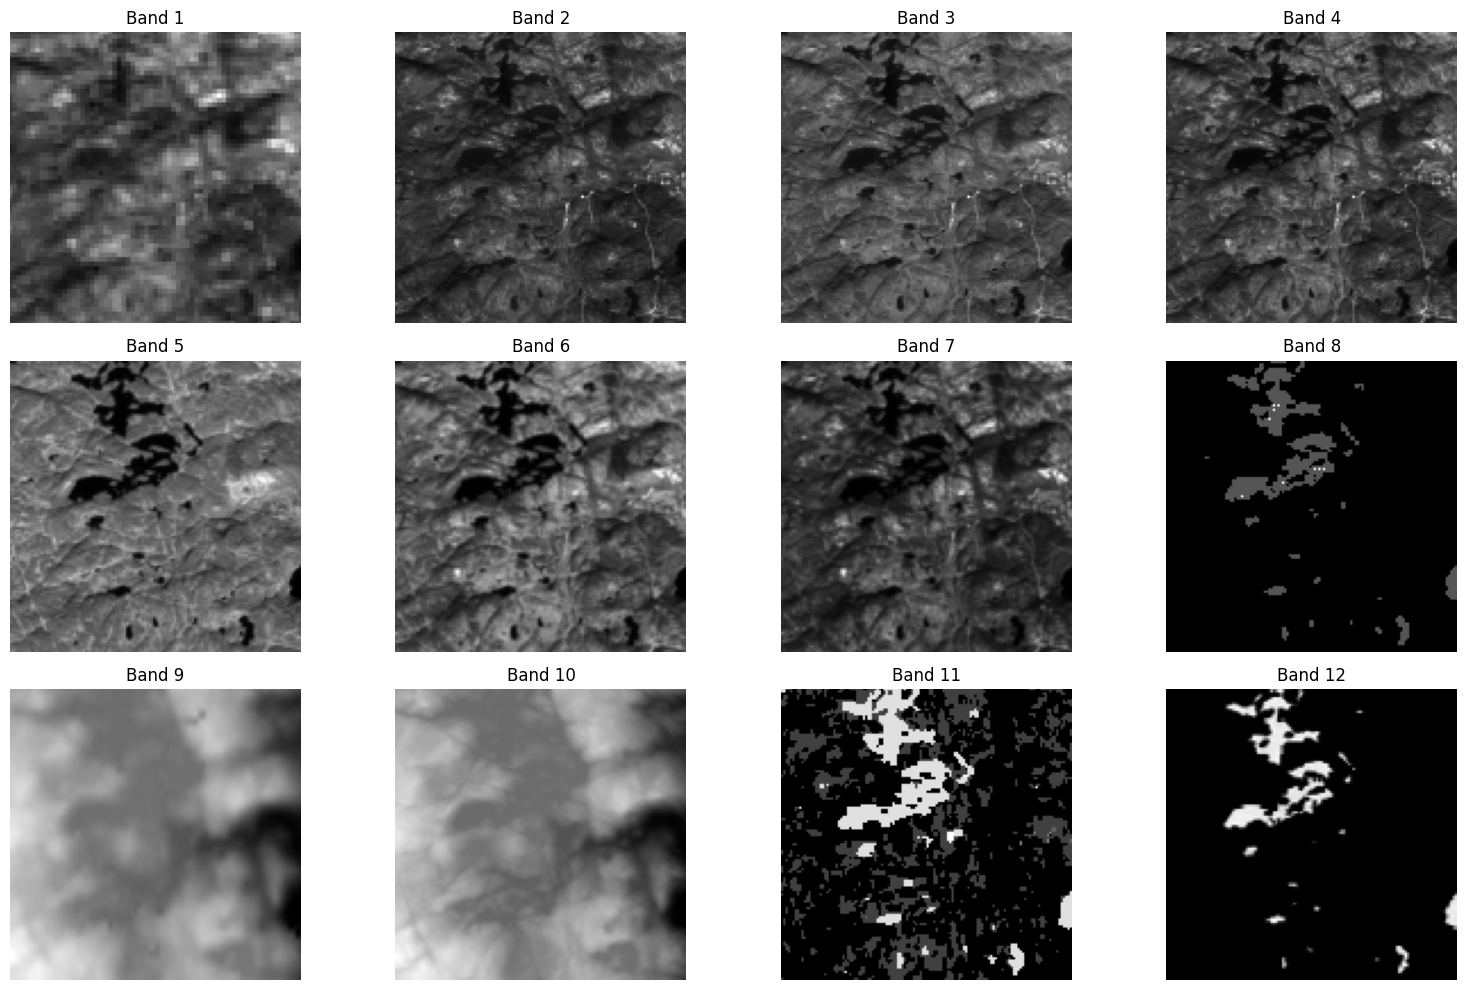

In [42]:
plt.figure(figsize=(16,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


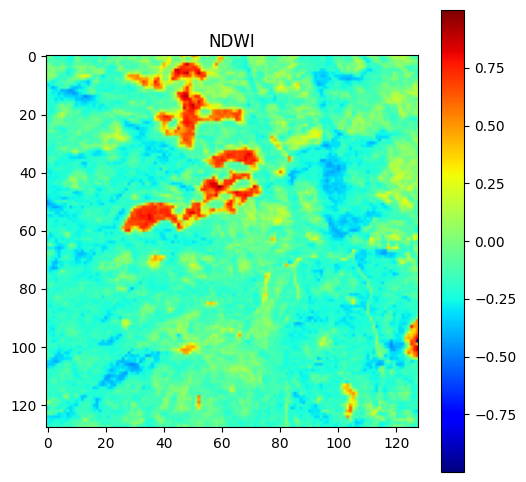

In [43]:
green = sample_image[:,:,2]
nir = sample_image[:,:,4]

ndwi = (green - nir) / (green + nir + 1e-6)

plt.figure(figsize=(6,6))
plt.imshow(ndwi, cmap='jet')
plt.title("NDWI")
plt.colorbar()
plt.show()


In [44]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import rasterio
import cv2

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Build paths
        img_path = os.path.join(self.image_dir, img_name)
        
        # Replace .tif with .png for mask
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        # -----------------------
        # LOAD MULTISPECTRAL IMAGE (.tif)
        # -----------------------
        with rasterio.open(img_path) as src:
            image = src.read()  # (C, H, W)

        image = np.transpose(image, (1, 2, 0))  # (H, W, C)
        image = image.astype(np.float32)

        # -----------------------
        # PER-BAND NORMALIZATION
        # -----------------------
        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        # -----------------------
        # LOAD MASK (.png)
        # -----------------------
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise ValueError(f"Mask not found or failed to load: {mask_path}")

        mask = (mask > 0).astype(np.float32)  # Ensure binary

        # -----------------------
        # CONVERT TO TENSOR
        # -----------------------
        image = torch.tensor(image).permute(2, 0, 1)  # (12,128,128)
        mask = torch.tensor(mask).unsqueeze(0)        # (1,128,128)

        return image, mask


In [47]:
# Create full dataset
full_dataset = WaterDataset(image_dir, label_dir)

# Create indices
indices = list(range(len(full_dataset)))

train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=42)

# Create subsets
from torch.utils.data import Subset

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))
print("Image tensor shape:", img.shape)
print("Mask tensor shape:", msk.shape)


Train size: 214
Validation size: 46
Test size: 46
Image tensor shape: torch.Size([12, 128, 128])
Mask tensor shape: torch.Size([1, 128, 128])


In [33]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [48]:
epochs = 20

for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)

    print(f"\nEpoch {epoch+1}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00,  7.45it/s, val_loss=0.583]



Epoch 1: Train Loss=0.4626 | Val Loss=0.5933



Epoch 2/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.49it/s, val_loss=0.559]



Epoch 2: Train Loss=0.3723 | Val Loss=0.5746



Epoch 3/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.21it/s, val_loss=0.557]



Epoch 3: Train Loss=0.3460 | Val Loss=0.5759



Epoch 4/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.79it/s, val_loss=0.557]



Epoch 4: Train Loss=0.3295 | Val Loss=0.5752



Epoch 5/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.77it/s, val_loss=0.556]



Epoch 5: Train Loss=0.3490 | Val Loss=0.5722



Epoch 6/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.37it/s, val_loss=0.569]



Epoch 6: Train Loss=0.3225 | Val Loss=0.5814



Epoch 7/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.68it/s, val_loss=0.565]



Epoch 7: Train Loss=0.3168 | Val Loss=0.5786



Epoch 8/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.17it/s, val_loss=0.561]



Epoch 8: Train Loss=0.3129 | Val Loss=0.5740



Epoch 9/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.39it/s, val_loss=0.555]



Epoch 9: Train Loss=0.3075 | Val Loss=0.5730



Epoch 10/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.49it/s, val_loss=0.593]



Epoch 10: Train Loss=0.2921 | Val Loss=0.6014



Epoch 11/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.36it/s, val_loss=0.565]



Epoch 11: Train Loss=0.3168 | Val Loss=0.5801



Epoch 12/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.50it/s, val_loss=0.558]



Epoch 12: Train Loss=0.2812 | Val Loss=0.5732



Epoch 13/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.51it/s, val_loss=0.577]



Epoch 13: Train Loss=0.2927 | Val Loss=0.5909



Epoch 14/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.69it/s, val_loss=0.565]



Epoch 14: Train Loss=0.2849 | Val Loss=0.5816



Epoch 15/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.33it/s, val_loss=0.583]



Epoch 15: Train Loss=0.2751 | Val Loss=0.5978



Epoch 16/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.76it/s, val_loss=0.554]



Epoch 16: Train Loss=0.3032 | Val Loss=0.5790



Epoch 17/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.92it/s, val_loss=0.599]



Epoch 17: Train Loss=0.2641 | Val Loss=0.6073



Epoch 18/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.11it/s, val_loss=0.571]



Epoch 18: Train Loss=0.2770 | Val Loss=0.5835



Epoch 19/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 14.48it/s, val_loss=0.572]



Epoch 19: Train Loss=0.2638 | Val Loss=0.5843



Epoch 20/20 [Validation]: 100%|██████████| 6/6 [00:00<00:00, 13.83it/s, val_loss=0.565]


Epoch 20: Train Loss=0.2683 | Val Loss=0.5784



In [52]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nTest Set Metrics (Water Class Only):")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 6/6 [00:00<00:00,  7.94it/s]


Test Set Metrics (Water Class Only):
Precision: 0.1979
Recall:    0.9801
IoU:       0.1971
F1-score:  0.3293


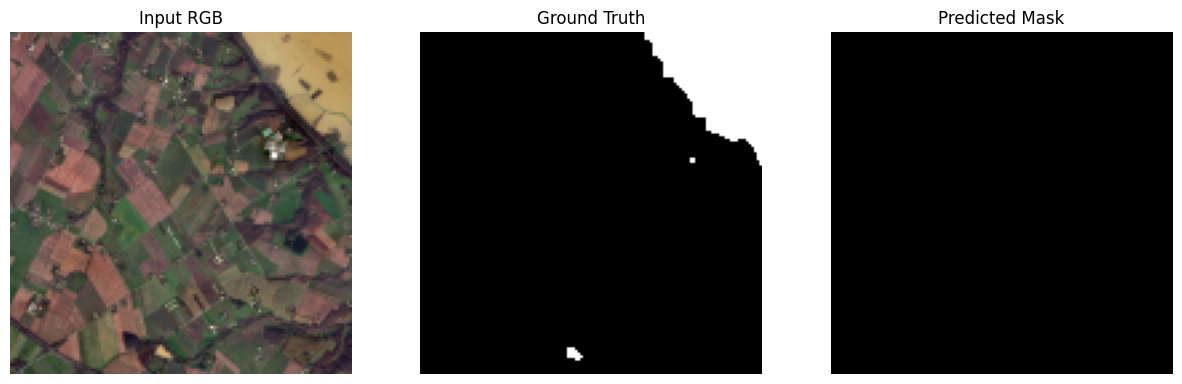

In [53]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

# Move to CPU
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

# Select first image in batch
img = images[0]
gt = masks[0][0]
pred = preds[0][0]

# Create RGB visualization (assuming Red=3, Green=2, Blue=1)
rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()
